In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume/NithinS-Resume.pdf


In [6]:

from copy import deepcopy

# Clean-up prompt
prompt_clean = "Clean the following resume by removing special characters and unnecessary text. Resume: {}"

# Descriptions for Subagents
subagent_desc = {
    "Impact": {
        "Quantify impact": "Use specific numbers, percentages, or metrics to clearly demonstrate the scale and significance of achievements.",
        "Repetition": "Maintain consistent language but avoid repeating phrases or descriptions across multiple sections.",
        "Weak verbs": "Use strong, action-oriented verbs to effectively highlight contributions and responsibilities.",
        "Verb tenses": "Ensure consistent use of present tense for current roles and past tense for previous roles.",
        "Responsibilities": "Highlight key tasks relevant to the job applied for, avoiding generic job descriptions.",
        "Spelling & consistency": "Ensure there are no spelling errors and formatting, capitalization, and punctuation remain consistent throughout."
    },
    
    "Brevity": {
        "Length": "Keep the resume concise—typically one page for entry-level positions or two for extensive experience.",
        "Bullet Lengths": "Ensure bullet points are concise (1-2 lines), focusing on key achievements and contributions.",
        "Filler Words": "Minimize filler words to maintain brevity and maximize the impact of each statement."
    },
    
    "Style": {
        "Buzzwords": "Incorporate relevant industry-specific keywords and terms that align with the job description.",
        "Dates": "Ensure employment dates follow a consistent format (e.g., MM/YYYY) and account for any unexplained gaps.",
        "Contact and Personal Details": "Clearly display name, contact information, and other essential personal details.",
        "Readability": "Use a simple, clean layout and font that is easy for ATS systems to parse. Avoid complex formatting or tables.",
        "Personal Pronouns": "Minimize the use of personal pronouns (e.g., 'I', 'me', 'my') to keep focus on achievements.",
        "Active Voice": "Use active voice to describe responsibilities and accomplishments, making the resume more impactful.",
        "Consistency": "Ensure formatting, language, and style are consistent throughout for a professional presentation."
    },
    
    "Sections": {
        "Summary": "Provide a concise overview of qualifications, experience, and career goals.",
        "Education": "Include academic background, such as degrees, institutions, and relevant coursework or achievements.",
        "Unnecessary Sections": "Omit irrelevant sections, such as hobbies or interests, unless they add specific value.",
        "Skills": "List technical, soft, and transferable skills relevant to the job to demonstrate your capabilities."
    }
}

# Descriptions for Agents
agent_desc = {
    "Impact": "Ensure the resume highlights achievements, contributions, and the value brought to employers.",
    "Brevity": "Keep the resume focused and easy to scan, ideally one page for entry-level and two pages for extensive experience.",
    "Style": "Ensure the layout, formatting, and visual appeal are clean, consistent, and professional.",
    "Sections": "Verify that key resume sections (Summary, Education, Work Experience, Skills) are included and relevant."
}

# Prompt for Subagent
prompt_subagent = ("As a Resume Expert, you are tasked with analyzing this resume for {} in the area of {}. "
                   "Provide a score out of 10 and suggest improvements in 1-2 lines. Output both the score and feedback.")

# Prompt for Agent
prompt_agent = ("You are a Resume Expert analyzing the resume for {} regarding {}. Summarize the sub-agent feedback and "
                "provide a score out of 10, along with improvement suggestions in 1-2 lines. No bullet points or headings. "
                "Feedback report: {}")

# Prompt for Superagent
prompt_superagent = ("You are a Resume Expert tasked with giving a final score based on the feedback provided. "
                     "Rate the resume on a scale of 10 using the following analogy: "
                     "Score 3 or less: Trash, Score 5 or less: Needs major improvements, Score 6-7: Average, Score 8-9: Excellent, "
                     "Score 10: Exceptional. Provide the score and a brief paragraph with your reasoning. Feedback: {}")


agent_subagent_pairs={}
for main_key, nested_dict in subagent_desc.items():  # Fix variable name
    pairs = {main_key: list(nested_dict.keys())}
    agent_subagent_pairs.update(pairs)

history=deepcopy(subagent_desc)

for key,value in history.items():
    if isinstance(value,dict):
        value['Overall']=""
        for nested_key,nested_value in value.items():
            value[nested_key]=""

In [10]:
!pip install langgraph
!pip install langchain-google-genai
!pip install PyPDF2
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END
import random
import time
import PyPDF2
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
import time

GOOGLE_API_KEY='fill your google api key'
genai.configure(api_key=GOOGLE_API_KEY)
model=ChatGoogleGenerativeAI(model='gemini-pro',google_api_key=GOOGLE_API_KEY)

def llm(x):
    return model.invoke(x).content

In [16]:
class GraphState(TypedDict):
    subagent_feedback: Optional[list]=[]
    agent_feedback: Optional[list]=[]
    history: Optional[dict]={}
    resume: Optional[str]=None
    final_verdict: Optional[str]=None
    all_pairs: Optional[str]=None
    subagent: Optional[str]=None
    agent: Optional[str]=None

workflow= StateGraph(GraphState)

def handle_clean(state):
    resume= state.get('resume')
    print("Cleaning loaded text...")
    resume = llm(prompt_clean.format(resume))
    return {'resume':resume}

def handle_subagent(state):
    time.sleep(5)
    history=state.get('history')
    subagent_feedback= state.get('subagent_feedback')
    resume=state.get('resume')
    all_pairs=state.get('all_pairs')
    
    agent = list(all_pairs.keys())[0]
    subagent=all_pairs[agent][0]
    
    current_feedback = llm(prompt_subagent.format(subagent,subagent_desc[agent][subagent],resume))
    subagent_feedback.extend(["{} : {}".format(subagent,current_feedback)])
    history[agent][subagent]=current_feedback
    all_pairs[agent].remove(subagent)
    return {'subagent_feedback':subagent_feedback,'history':history,'all_pairs':all_pairs,'agent':agent}

def handle_agent(state):
    time.sleep(5)
    feedback=state.get('subagent_feedback')
    agent_feedback=state.get('agent_feedback')
    all_pairs=state.get('all_pairs')
    history=state.get('history')
    
    agent=list(all_pairs.keys())[0]
    
    print("Reveiwing {} ... ".format(agent))
    
    summary = llm(prompt_agent.format(agent,agent_desc[agent],feedback))
    agent_feedback.extend(["{} : {}".format(agent,summary)])
    history[agent]['Overall']=summary
    
    del all_pairs[agent]
    
    try:
        agent=list(all_pairs.keys())[0]
    except:
        pass
    return {'agent_feedback':agent_feedback,'history':history,'all_pairs':all_pairs,'agent':agent}

def handle_superagent(state):
    time.sleep(5)
    print("Final verdict getting updated...")
    history= state.get('history')
    feedback=state.get('agent_feedback')
    result=llm(prompt_superagent.format(feedback))
    history.update({"Final Verdict":result})
    return {'final_verdict':result,'history':history}
    

In [17]:
workflow.add_node("handle_clean",handle_clean)
workflow.add_node("handle_subagent",handle_subagent)
workflow.add_node('handle_agent',handle_agent)
workflow.add_node('handle_superagent',handle_superagent)

In [18]:
def subagent_check(state):
    agent=state.get('agent')
    all_pairs=state.get('all_pairs')
    if len(all_pairs[agent]):
        return "handle_subagent"
    else:
        return "handle_agent"

def agent_check(state):
    all_pairs = state.get('all_pairs')
    if len(all_pairs.keys()):
        return "handle_subagent"
    else:  
        return "handle_superagent"

workflow.add_conditional_edges(
    "handle_subagent",
    subagent_check,
    {
        "handle_subagent":"handle_subagent",
        "handle_agent":"handle_agent"
    }
)

workflow.add_conditional_edges(
    "handle_agent",
    agent_check,
    {
        "handle_subagent":"handle_subagent",
        "handle_superagent":"handle_superagent"
    }
)

workflow.set_entry_point("handle_clean")
workflow.add_edge('handle_clean','handle_subagent')
workflow.add_edge('handle_superagent',END)

In [19]:
app = workflow.compile()

In [20]:
!pip install PyPDF2
import PyPDF2
lines=[]
with open("/kaggle/input/resume/NithinS-Resume.pdf",'rb') as file:
    pdf_reader=PyPDF2.PdfReader(file)
    num_pages=len(pdf_reader.pages)
    for page_num in range(num_pages):
        page=pdf_reader.pages[page_num]
        page_text=page.extract_text()
        page_lines=page_text.split('\n')
        lines.extend(page_lines)
lines='\n'.join(lines)

I0000 00:00:1727454725.462543      36 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [21]:
lines

'Nithin S\n+91 8431751290 |sureshnithin1729@gmail.com |Linkedin |github.com/Nithin1729S |nithins.vercel.app\nEducation\nNational Institute of Technology Karnataka, Surathkal |9.58 CGPA Nov 2022 - Aug 2026\nB.Tech in Information Technology and Minor in Machine Learning\nRelevant Courses : Data Structures and Algorithms, Database Management Systems, Operating Systems, Computer\nNetworking, Web Technologies, Object Oriented Programming, Mathematics for Machine Learning and Data Science.\nTechnical Skills\nLanguages : C/C++, Python, Java, JavaScript\nTechnologies/Frameworks : HTML/CSS, Tailwind CSS, ReactJS, NodeJS, ExpressJS, SQL, Flask, Django\nDeveloper Tools : VS Code, Linux, Git/GitHub, Docker, MongoDB, APIs, Cloudinary, Firebase, Streamlit, Vercel, Postman\nCertifications :Data Structures & Algorithm (Abdul Bari) ,Machine Learning (Andrew Ng) ,Java Programming\n(Abdul Bari) ,Full Stack Web Development (Udemy)\nInternships\nHealthcare Analytics & Language Engineering Lab |Demo |GitHub

In [24]:
agent=list(agent_subagent_pairs.keys())[0]
subagent=agent_subagent_pairs[agent][0]
conversation = app.invoke(
    {
        'subagent_feedback': [],
        'agent_feedback': [], 
        'history': history,
        'resume': lines,
        'all_pairs': deepcopy(agent_subagent_pairs),
        'agent': agent,
        'subagent': subagent
    },
    {'recursion_limit': 100}
)

Cleaning loaded text...
Reveiwing Impact ... 
Reveiwing Brevity ... 
Reveiwing Style ... 
Reveiwing Sections ... 
Final verdict getting updated...


In [25]:
conversation.keys()

dict_keys(['subagent_feedback', 'agent_feedback', 'history', 'resume', 'final_verdict', 'all_pairs', 'subagent', 'agent'])

I0000 00:00:1727455064.467281      36 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 1.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=97928 sha256=e6f5ecd4a5ab3b57e293187b5f42322a67e3005ad532567e17dd038a96a495ca
  Stored in directory: /root/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


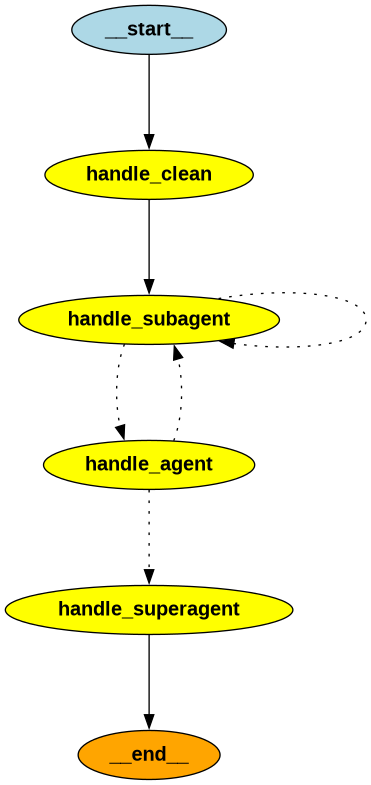

In [28]:
!pip install pygraphviz
from IPython.display import Image
Image(app.get_graph().draw_png())

In [33]:
for key, value in conversation.items():
    print(f"==== {key.upper()} ====\n")  # Add a header for each key
    if isinstance(value, list):  # Check if the value is a list, print each item on a new line
        for item in value:
            print(f"- {item}\n")
    elif isinstance(value, dict):  # If it's a dictionary, print key-value pairs
        for subkey, subvalue in value.items():
            print(f"{subkey}: {subvalue}\n")
    else:  # If it's just a regular value, print it
        print(f"{value}\n")
    print("-" * 50)  # Add a separator between entries


==== SUBAGENT_FEEDBACK ====

- Quantify impact : **Score:** 6/10

**Feedback:**

* The resume lacks specific numbers, percentages, or metrics to quantify the impact of achievements.
* Add quantifiable results to highlight the scale and significance of accomplishments, such as increasing sales by 15% or reducing operational costs by $50,000.

- Repetition : **Score:** 7/10

**Feedback:**

* The resume contains some repetition in the use of phrases like "developed and implemented" and "managed and executed."
* To improve, consider using more varied language and highlighting specific accomplishments in each section to showcase a wider range of skills and experience.

- Weak verbs : **Score:** 5/10

**Feedback:**

The resume contains some weak verbs, such as "assisted," "supported," and "participated." To improve, consider replacing these verbs with stronger action-oriented verbs that more effectively convey the candidate's contributions, such as "managed," "developed," and "implemented."
